<a href="https://colab.research.google.com/github/Park-hanna/BDA_study/blob/main/NLP/RNN_Create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install unicodedata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement unicodedata (from versions: none)
ERROR: No matching distribution found for unicodedata


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

def readLines(filename):
  with open(filename, encoding='utf-8') as some_file:
    return [unicodeToAscii(line.strip()) for line in some_file]

category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/MyDrive/Data/data/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
  raise RuntimeError('Data not found. Make sure that you downloaded data'
        'form https://download.pytorch.org/tutorial.data.zip and extract it to '
        'the current directory.')

print('# Categories :', n_categories, all_categories)
print(unicodeToAscii("0'Néàl"))

# Categories : 18 ['Greek', 'Italian', 'Polish', 'Czech', 'Arabic', 'Korean', 'Spanish', 'Portuguese', 'Chinese', 'Irish', 'Russian', 'German', 'Dutch', 'English', 'Scottish', 'Japanese', 'French', 'Vietnamese']
'Neal


In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [ ]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]


def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line

In [ ]:
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

def targetTensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letter_indexes.append(n_letters - 1)
  return torch.LongTensor(letter_indexes)

In [ ]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [ ]:
import time
import math

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s -= m*60
  return '%dm %ds'%(m,s)


In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters+1):
  output, loss = train(*randomTrainingExample())
  total_loss += loss

  if iter % print_every == 0:
    print('%s (%d %d%%) %.4f' %(timeSince(start), iter, iter/n_iters * 100, loss))

  if iter % plot_every == 0:
    all_losses.append(total_loss / plot_every)
    total_loss = 0

0m 15s (5000 5%) 2.7827
0m 31s (10000 10%) 2.5790
0m 47s (15000 15%) 2.3598
1m 2s (20000 20%) 2.7170
1m 18s (25000 25%) 2.6047
1m 34s (30000 30%) 3.1336
1m 50s (35000 35%) 1.5251
2m 5s (40000 40%) 1.6521
2m 21s (45000 45%) 2.7992
2m 37s (50000 50%) 2.3569
2m 52s (55000 55%) 2.2487
3m 7s (60000 60%) 2.5645
3m 22s (65000 65%) 2.0476
3m 38s (70000 70%) 1.8301
3m 55s (75000 75%) 2.5897
4m 10s (80000 80%) 2.0199
4m 25s (85000 85%) 2.6327
4m 40s (90000 90%) 1.7371
4m 56s (95000 95%) 2.1668
5m 11s (100000 100%) 3.6867


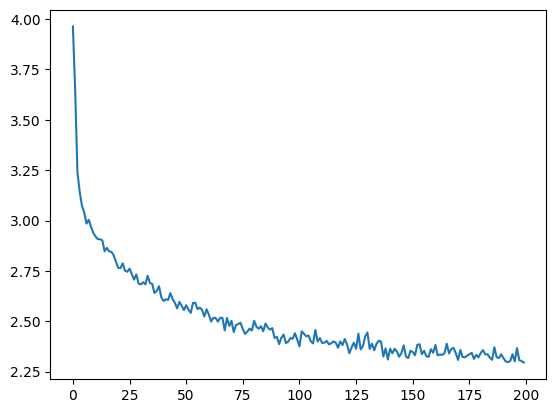

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
from numpy.core.arrayprint import format_float_scientific
max_length = 20

def sample(category, start_letter = 'A'):
  with torch.no_grad():
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters - 1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      input = inputTensor(letter)

    return output_name

def samples(category, start_letters = 'ABC'):
  for start_letter in start_letters:
    print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Roullov
Uanton
Shavan
Gell
Eren
Roun
Santa
Paner
Alan
Cha
Han
Iun
